# Statistique Computationnelle - TP 1

## Exercice 3 : Apprentissage par gradient stochastique

In [19]:
import numpy as np
import pylab as pl
import matplotlib.animation as anim

### Question 1

Le risque empirique est donné par :
$$ R_n(w) = \mathbb{E}_{z \sim \mu_n} \left[ J(w, z) \right] = \dfrac{1}{n} \sum_{i = 1}^n \left( y_i - w^\mathsf{T} x_i \right)^2 $$
Où $\mu_n$ est la distribution uniforme sue l'ensemble $\{ z_i \}_{1 \leqslant i \leqslant n}$ avec $z_i = (x_i, y_i)$. Pour la descente de gradient stochastique on a besoin du gradient de $J$ par rapport à $w$ :
$$ \nabla_w J(w, z) = - 2 \left( y - w^\mathsf{T} x \right) x $$
Ensuite dans les hypothèses de convergences vu en cours ce gradient doit être borné. Or ici pour $x$ non nul et $w = \lambda x$ lorsque $\lambda$ tend vers l'infini le gradient est clairement non borné. C'est pourquoi je projette $w$ sur la sphère unité. Ainsi on a :
$$ \left\| \nabla_w J(w, z) \right\| \leqslant 2 \left( 1 + \| x \| \right) \, \| x \| $$
Comme notre nombre d'observation est fini, la norme de $x$ est borné donc le gradient est bien borné. Cette projection ne modifie pas l'ensemble des hyperplans obtenables car la norme de $w$ n'a aucune influence sur l'hyperplan. Finalement notre fonction $J$ a toutes les autres propriétés souhaitées : convexe, différentiable, ...  
Enfin pour une séquence $(\epsilon_k)_{k > 0}$ vérifiant les hypothèses pour la convergence, à savoir :
$$ \sum_{k > 0} \epsilon_k = + \infty \qquad \sum_{k > 0} \epsilon_k^2 < + \infty $$
l'algorithme suivant converge alors vers une solution optimal.

In [33]:
def inverseSeq():
	"""
	Generator of the infinite sequence of inversed integers
	"""
	n = 1
	while True:
		yield 1 / n
		n += 1

def stochastic_gradient_descent(Z, w0, epsilon, K, nFrames=None, fig=None):
	"""
	Compute and return a hyperplane `w` that separates labeled observations contained in `Z` using a
	stochastic gradient descent.

	Parameters
	----------
	Z : list of observations
	w0 : array of float
		Represent the hyperplane used to start the algorithm
	epsilon : float generator
		This generator is used to scale the updates of the `w`
	K : int
		Maximal number of steps of the algorithm
	nFrames : int or None, optional
		If different from None then it is the number of frames to show in a gif saved in the file `res.gif`
    fig : Figure
        The figure on which the we plot
	"""
	w = w0.copy()
	if nFrames != None:
		ims = []
		a, b, c = plot_result(Z, w)
		ims.append([a, b, c, pl.text(1, 1, 'k = 0')])
		p = max(K // (nFrames - 1), 1)
	n = len(Z)
	for k in range(K):
		# Draw an observation
		x, y = Z[np.random.randint(n)]
		# Computation of the gradient
		grad = - 2 * (y - np.dot(w, x)) * x
		# Update of w
		e = next(epsilon)
		w -= e * grad
		# Projection on the unit sphere
		w /= np.linalg.norm(w)
		# Plot the hyperplane if needed
		if nFrames != None and (k+1) % p == 0:
			ims.append([a, b, plot_sep(w), pl.text(1, 1, f'k = {k}')])
	if nFrames != None:
		ani = anim.ArtistAnimation(fig, ims, interval=300, repeat=True)
		ani.save('res.gif', writer='imagemagick')
	return w

La fonction `inverseSeq` donne la suite des inverses qui est bien une suite $(\epsilon_k)_{k > 0}$ vérifiant les hypothèses voulus.

### Question 2

La fonction `generate_sample` tire un hyperplan uniformément dans $\mathcal{S}_1$ puis tire $n$ observations uniformément dans la boule unité.

In [21]:
def drawUnitVector():
	"""
	Return a random 2D vector drawn uniformly on the unit sphere
	"""
	theta = np.random.uniform(0, 2*np.math.pi)
	return np.array((np.math.cos(theta), np.math.sin(theta)))

def generate_sample(n):
	"""
	Generate and return a list of observations `(x, y)` with:
	- `x` a 2D vector drawn uniformly in the 2D ball
	- `y` is the label of x in {-1, 1} depending on the side of the hyperplane `w` the point `x` is

	Where `w` is a hyperplane drawn uniformly on the 2D sphere

	Parameters
	----------
	n : int
		The number of observations generated
	"""
	w = drawUnitVector()
	print("Data generated with w =", w)
	sample = []
	for _ in range(n):
		r = np.random.rand()
		x = (r ** 0.5) * drawUnitVector()
		y = 1 if np.dot(w, x) > 0 else -1
		sample.append([x, y])
	return sample

### Question 3

Je commence par définir quelques fonctions pour obtenir le score (i.e. le ratio de bonne prédiction dans l'ensembles des observations).

In [22]:
def score(Z, w):
	"""
	Return the score of the hyperplane `w` on the observations of `Z`. The score is the ratio between
	the number of correctly predicted observations and the total number of observations.

	Parameters
	----------
	Z : list of observations
	w : array of float
		Represent the normal vector of the hyperplane for which we want to know the score
	"""
	n = len(Z)
	correct = 0
	for x, y in Z:
		if y*np.dot(w, x) > 0: correct += 1
	return correct / n

def plot_sep(w):
	"""
	Plot the separation line defined by `w`

	Parameters
	----------
	w : array of float
		Represent the normal vector of the hyperplane to plot
	"""
	sep = (1.2 / (w[0]**2 + w[1]**2))**0.5 * np.array((-w[1], w[0]))
	return pl.plot([-sep[0], sep[0]], [-sep[1], sep[1]], color='black')[0]

def plot_result(Z, w):
	"""
	Plot observations and the hyperplane obtained in the 2D plane

	Parameters
	----------
	Z : list of observations
	w : array of float
		Represent the normal vector of the hyperplane to plot
	"""
	xs = {1:[], -1:[]}
	ys = {1:[], -1:[]}
	for x, y in Z:
		xs[y].append(x[0])
		ys[y].append(x[1])
	a = pl.scatter(xs[1], ys[1], color='b')
	b = pl.scatter(xs[-1], ys[-1], color='r')
	c = plot_sep(w)
	return a, b, c

Voici ensuite quelques paramètres que l'utilisateur à la possibilité de modifier, ainsi que la portion de code pour tester l'algorithme. si `nFrames` est un entier strictement plus grand que 1 alors une animation gif est créé dans le fichier [res.gif](res.gif).

Data generated with w = [-0.25050288  0.96811586]
Hyperplan learned w = [-0.34814786  0.93743963]
Obtained score (ratio of well predicted observations) is s = 0.99


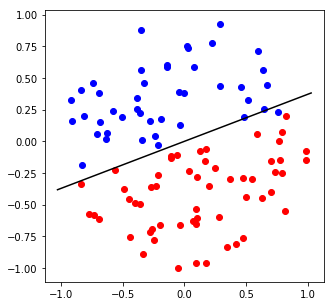

In [36]:
####### PARAMETERS #######
n = 100             # Number of observations
K = 500             # Number of iterations
nFrames = None      # If you want to create a gif of the gradient descent
##########################

fig = pl.figure(figsize=(5, 5))
Z = generate_sample(n)
w_opt = stochastic_gradient_descent(Z, drawUnitVector(), inverseSeq(), K, nFrames, fig)
print("Hyperplan learned w =", w_opt)
print("Obtained score (ratio of well predicted observations) is s =", score(Z, w_opt))
pl.clf()
plot_result(Z, w_opt)
pl.show()

Exemple de gif obtenu dans le fichier [res.gif](res.gif)
![res.gif](res.gif)

### Question 4

In [37]:
def addNoise(Z, sigma):
	"""
	Add some gaussian noise to a list of observations

	Parameters
	----------
	Z : list of observations
	sigma : float
		The Standard deviation used in the gaussian
	"""
	for x, _ in Z:
		x += np.random.normal(np.array([0, 0]), sigma)

In [38]:
####### PARAMETERS #######
n = 100             # Number of observations
sigma = 0.2         # Standard deviation of the noise
K = 500             # Number of iterations
nFrames = None      # If you want to create a gif of the gradient descent
##########################

fig = pl.figure(figsize=(5, 5))
Z = generate_sample(n)
addNoise(Z, sigma)
w_opt = stochastic_gradient_descent(Z, drawUnitVector(), inverseSeq(), K, nFrames, fig)
print("Hyperplan learned w =", w_opt)
print("Obtained score (ratio of well predicted observations) is s =", score(Z, w_opt))
pl.clf()
plot_result(Z, w_opt)
pl.show()

Data generated with w = [-0.62721976 -0.77884233]
Hyperplan learned w = [-0.51034703 -0.85996855]
Obtained score (ratio of well predicted observations) is s = 0.91


### Question 5

Comme les données sont dans $\{0, ..., 10\}^9$, je commence par les normaliser en leur applquant la transformation $x \mapsto (x - 5) \, / \, \sqrt{9 \times 5^2}$ afin que tous les vecteurs soient contenu dans la boule unité et non pas dans le cadrant positif $\mathbf{R}_+^9$. Les labels sont aussi replacés dans $\{-1, 1\}$ au lieu de $\{2, 4\}$.

In [39]:
####### PARAMETERS #######
K = 10000
##########################

f = open("./breast-cancer-wisconsin.data", "r")
Z = []
for l in f.readlines():
	if '?' in l: continue
	l = l.split(',')
	x = (np.array(list(map(float, l[1:-1]))) - 5) / (9*5**2) ** 0.5
	y = int(l[-1]) - 3
	Z.append([x, y])
w0 = (np.random.rand(9) - 0.5)
w_opt = stochastic_gradient_descent(Z, w0, inverseSeq(), K)
print("Hyperplan learned w =", w_opt)
print("Obtained score (ratio of well predicted observations) is s =", score(Z, w_opt))

Hyperplan learned w = [0.34107651 0.37956637 0.37368627 0.30181972 0.22950548 0.49944951
 0.2849387  0.33947755 0.10149861]
Obtained score (ratio of well predicted observations) is s = 0.9385065885797951
